In [ ]:
# @title
#installation des packages
!pip install yfinance
!pip install yfinance forex-python
!pip install unidecode
!pip install pytz
!pip install tqdm
!pip install --upgrade yfinance #(pour résoudre les bug "too many request")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.58
    Uninstalling yfinance-0.2.58:
      Successfully uninstalled yfinance-0.2.58


In [ ]:
# @title
#importation des packages
import yfinance as yf
import pandas as pd
import numpy as np
import time
from unidecode import unidecode
from tqdm import tqdm  # Import de tqdm pour la barre de progression


# on récupere les "ticker" de toutes les entreprises des indices via yahoo finance
indices_urls = {
    "s&p 500": "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    "nasdaq 100": "https://en.wikipedia.org/wiki/NASDAQ-100",
    "dow jones": "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average",
    "cac 40": "https://en.wikipedia.org/wiki/CAC_40",
    "ftse 100": "https://en.wikipedia.org/wiki/FTSE_100_Index",
    "dax": "https://en.wikipedia.org/wiki/DAX",
    "hang seng": "https://en.wikipedia.org/wiki/Hang_Seng_Index",
    "smi": "https://en.wikipedia.org/wiki/Swiss_Market_Index",
    "ibex 35": "https://en.wikipedia.org/wiki/IBEX_35"
}

# Affichage des indices disponibles sur la console
print("📊 Indices disponibles :")
for i, idx in enumerate(indices_urls.keys(), 1):
    print(f"  {i}. {idx.upper()}")

index_name = input("\nQuel indice veux-tu analyser ? (copie-colle un nom dans la liste ci-dessus) : ").lower().strip()
if index_name not in indices_urls:
    raise SystemExit

#récupération des ticker sur wikipédia
def get_index_tickers(index_name):
    url = indices_urls[index_name]
    tables = pd.read_html(url)

    if index_name == "hang seng":
        tickers = [
            f"{str(t).zfill(4)}.HK"
            for table in tables
            for t in table.values.flatten()
            if str(t).isdigit()
        ]
        return tickers

    for table in tables:
        table.columns = [str(col).strip().lower() for col in table.columns]
        if 'symbol' in table.columns or 'ticker' in table.columns:
            ticker_column = 'symbol' if 'symbol' in table.columns else 'ticker'
            tickers = table[ticker_column].tolist()

            tickers = [
                ticker.replace('.', '-')
                      .replace('-PA', '.PA')
                      .replace('-AS', '.AS')
                      .replace('-DE', '.DE')
                      .replace('-SW', '.SW')
                      .replace('-L', '.L')
                      .replace('-MC', '.MC')
                      .replace('-SA', '.SA')
                for ticker in tickers
            ]
            return tickers

    return []

#normalisation des
def normaliser(val, objectif, label):
    if val is None or val != val: #normalisation des valeurs manquantes
        return 0
    if "FCF" in label:
        if val >= 0: return 1
        elif val <= -0.10: return 0
        else: return 1 + (val / 0.10)
    if isinstance(objectif, tuple):
        bas, haut = objectif
        if bas <= val <= haut: return 1
        elif val < bas: return max(0, val / bas)
        else: return max(0, haut / val)
    inverser = {"PER", "Dette / CP"}
    if objectif == 0:
        return 1 if val >= 0 else 0
    if objectif == 0.03 and "CA" in label:
        if val >= 0: return 1
        elif val <= -0.15: return 0
        else: return 1 + (val / 0.15)
    if objectif == 0.10 and "RN" in label:
        if val >= 0: return 1
        elif val <= -0.15: return 0
        else: return 1 + (val / 0.15)
    if label in inverser:
        return 1 if val <= objectif else max(0, objectif / val)
    return 1 if val >= objectif else max(0, val / objectif)

def try_get(df, keys, col):
    for key in keys:
        if key in df.index:
            return df.loc[key][col]
    return None

def growth_rate(start, end):
    if start is None or end is None or start == 0:
        return None
    return (end - start) / abs(start)

def moyenne_croissance_par_annee(series):
    taux = []
    for i in range(1, len(series)):
        t = growth_rate(series[i-1], series[i])
        if t is not None:
            taux.append(t)
    return sum(taux)/len(taux) if taux else None

def extract_series(df, label, years):
    try:
        return [df.loc[label][year] if label in df.index else None for year in years]
    except:
        return [None]*len(years)

#objectifs
valeurs_cibles = {
    "Croissance CA": 0.03,
    "Croissance RN": 0.10,
    "Croissance FCF": 0.00,
    "Croissance Dividende": 0.00,
    "Marge nette": 0.15,
    "ROE": 0.10,
    "ROCE": 0.12,
    "PER": 12,
    "Payout Ratio": (0.30, 0.60),
    "Dette / CP": 0.80
}

#classement et sauvegarde en fichier excel
tickers = get_index_tickers(index_name)
if not tickers:
    raise SystemExit

resultats = []
total_tickers = len(tickers)

# Utilisation de tqdm pour afficher la barre de progression
for ticker in tqdm(tickers, desc="Traitement des entreprises", unit="entreprise"):
    try:
        entreprise = yf.Ticker(ticker)
        info = entreprise.info

        financials = entreprise.financials
        cashflow = entreprise.cashflow
        balance_sheet = entreprise.balance_sheet

        col = financials.columns[0] if financials.columns.size > 0 else None
        if not col:
            continue

        revenue = try_get(financials, ["Total Revenue"], col)
        net_income = try_get(financials, ["Net Income"], col)
        fcf = try_get(cashflow, ["Free Cash Flow"], col)

        total_debt = try_get(balance_sheet, ["Total Debt"], col)
        total_assets = try_get(balance_sheet, ["Total Assets"], col)
        current_liabilities = try_get(balance_sheet, ["Current Liabilities"], col)
        ebitda = info.get("ebitda")
        ebit = info.get("ebit") or ebitda
        debt_to_equity = info.get("debtToEquity")
        net_margin = net_income / revenue if net_income and revenue else None

        if info.get("sector", "").lower() in ["financial services", "insurance"]:
            roce = None
        else:
            roce = ebit / (total_assets - current_liabilities) if ebit and total_assets and current_liabilities else None

        income_stmt = entreprise.income_stmt
        cashflow_stmt = entreprise.cashflow

        all_years = sorted([col for col in income_stmt.columns], reverse=True)
        if len(all_years) < 4:
            continue

        years = sorted(all_years[:4])

        revenues = extract_series(income_stmt, "Total Revenue", years)
        net_incomes = extract_series(income_stmt, "Net Income", years)
        fcf_series = extract_series(cashflow_stmt, "Free Cash Flow", years)

        avg_growth_revenue = moyenne_croissance_par_annee(revenues)
        avg_growth_net_income = moyenne_croissance_par_annee(net_incomes)
        avg_growth_fcf = moyenne_croissance_par_annee(fcf_series)

        try:
            dividends_series = entreprise.dividends
            now_aware = pd.Timestamp.now(tz=dividends_series.index.tz)
            start_date = pd.Timestamp(years[0].year, 1, 1, tz=now_aware.tzinfo)
            end_date = pd.Timestamp(years[-1].year, 12, 31, tz=now_aware.tzinfo)
            divs = dividends_series[(dividends_series.index >= start_date) & (dividends_series.index <= end_date)]
            divs_per_year = divs.resample("YE").sum()
            dividend_values = divs_per_year.values.flatten().tolist()
            avg_growth_dividende = moyenne_croissance_par_annee(dividend_values)
        except:
            avg_growth_dividende = None

        valeurs_reelles = {
            "Croissance CA": avg_growth_revenue,
            "Croissance RN": avg_growth_net_income,
            "Croissance FCF": avg_growth_fcf,
            "Croissance Dividende": avg_growth_dividende,
            "Marge nette": net_margin,
            "ROE": info.get("returnOnEquity"),
            "ROCE": roce,
            "PER": info.get("trailingPE"),
            "Payout Ratio": info.get("payoutRatio"),
            "Dette / CP": debt_to_equity/100 if debt_to_equity else None
        }

        points_verts = 0
        for label, objectif in valeurs_cibles.items():
            val = valeurs_reelles[label]
            score = normaliser(val, objectif, label)
            if score >= 1:
                points_verts += 1

        resultats.append({
            "Ticker": ticker,
            "Entreprise": f"{info.get('longName', ticker)} ({ticker})",  # Affichage du nom avec le ticker
            "Points Verts": points_verts
        })

    except Exception as e:
        continue

# Création du DataFrame final avec le classement
df_resultats = pd.DataFrame(resultats)
df_resultats["Entreprise"] = df_resultats["Entreprise"].apply(lambda x: unidecode(str(x)))
df_resultats = df_resultats.sort_values(by="Points Verts", ascending=False)

# Affichage du classement final
print(df_resultats[["Entreprise", "Points Verts"]].to_string(index=False))

# Sauvegarde des résultats dans un fichier Excel
df_resultats.to_excel("classement_entreprises.xlsx", index=False)  # Sauvegarde dans un fichier Excel


📊 Indices disponibles :
  1. S&P 500
  2. NASDAQ 100
  3. DOW JONES
  4. CAC 40
  5. FTSE 100
  6. DAX
  7. HANG SENG
  8. SMI
  9. IBEX 35

Quel indice veux-tu analyser ? (copie-colle un nom dans la liste ci-dessus) : CAC 40


Traitement des entreprises: 100%|██████████| 40/40 [00:38<00:00,  1.05entreprise/s]

                                                                              Entreprise  Points Verts
                                                               TotalEnergies SE (TTE.PA)             9
                         Hermes International Societe en commandite par actions (RMS.PA)             9
                                                              L'Air Liquide S.A. (AI.PA)             8
                                                           Publicis Groupe S.A. (PUB.PA)             8
                                                                    L'Oreal S.A. (OR.PA)             8
                                                                      Legrand SA (LR.PA)             8
                                                         Schneider Electric S.E. (SU.PA)             8
                                                 Compagnie de Saint-Gobain S.A. (SGO.PA)             8
                          LVMH Moet Hennessy - Louis Vuitton, Societe Eur

Entrez le nom de l'action : renault
Le libellé pour l'action 'renault' est : RNO.PA

--- Analyse fondamentale de Renault SA ---
Secteur : Consumer Cyclical
Pays : France
Capitalisation boursière : 13.8 Md $

Chiffre d'affaires : 52 376 M $
Résultat net : 2 198 M $
Free cash-flow : 1 398 M $

PER : 18.423079
Payout ratio : 71.3 %
Marge nette : 4.2 %

ROE : 2.9 %
ROCE : 14.0 %

Dettes / Capitaux propres : 230.50 %
Dettes / EBITDA : 10.59

Dividende par action : 2.2 $
Prix actuel de l'action : 47.9 $
Dernier dividende versé : 08/05/2025
Prochain dividende prévu : N/A
Dividend Yield : 4.57 %

Chiffre d'affaires
  2020 : 43 474 M $
  2021 : 41 659 M $
  2022 : 46 328 M $
  2023 : 52 376 M $
  Croissance 2020 → 2021 : -4.2 %
  Croissance 2021 → 2022 : 11.2 %
  Croissance 2022 → 2023 : 13.1 %

Résultat net
  2020 : -8 008 M $
  2021 : 888 M $
  2022 : -354 M $
  2023 : 2 198 M $
  Croissance 2020 → 2021 : 111.1 %
  Croissance 2021 → 2022 : -139.9 %
  Croissance 2022 → 2023 : 720.9 %

Marge ne

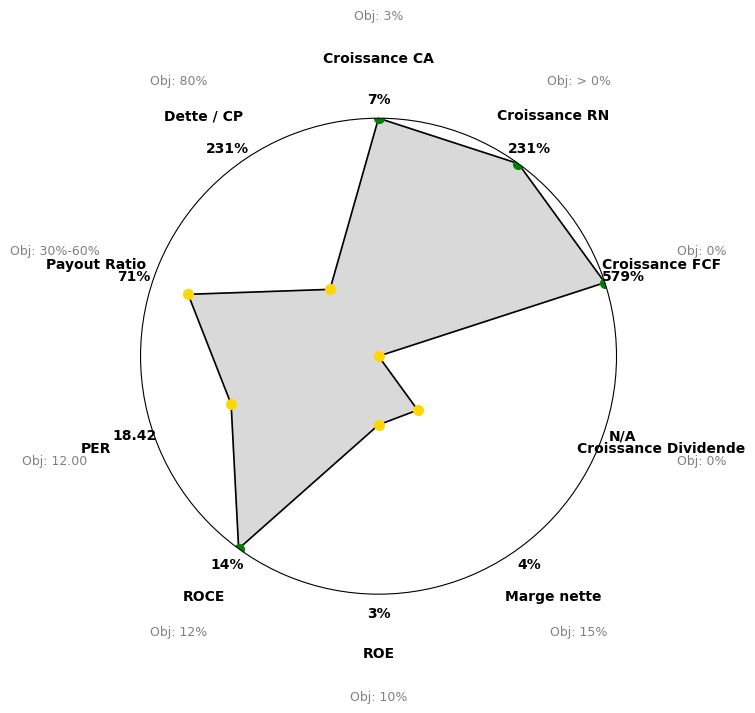

In [ ]:
# @title
import requests
import pandas as pd
from unidecode import unidecode

# URL du fichier avec 'dl=1' pour le téléchargement direct
url = 'https://www.dropbox.com/scl/fi/ft1mmc791yozgggpcy8iw/libell-s.xlsx?rlkey=ky4pesp2l4mqy6uoj7dijbwcz&st=npjt07co&dl=1'

# Effectuer la requête pour télécharger le fichier
response = requests.get(url)

# Vérifier si la requête a réussi
if response.status_code == 200:
    # Sauvegarder le contenu dans un fichier local
    with open('lib-ll-s.xlsx', 'wb') as file:
        file.write(response.content)

    # Charger le fichier Excel dans une DataFrame, spécifier le moteur 'openpyxl'
    df = pd.read_excel('lib-ll-s.xlsx', sheet_name='Feuil2', engine='openpyxl')  # Lire la feuille 'Feuil2'

    # Demander à l'utilisateur de saisir le nom d'une action
    action_name = input("Entrez le nom de l'action : ").strip().lower()

    # Normaliser le texte : retirer accents et ponctuation
    action_name_normalized = unidecode(action_name)  # Enlever les accents
    action_name_normalized = ''.join(e for e in action_name_normalized if e.isalnum() or e.isspace()).lower()  # Retirer la ponctuation

    # Rechercher l'action dans la DataFrame en normalisant également les noms dans la DataFrame
    df['nom_normalized'] = df['nom'].apply(lambda x: unidecode(str(x)).lower())

    # Rechercher un match partiel (utiliser 'str.contains' pour une recherche flexible)
    result = df[df['nom_normalized'].str.contains(action_name_normalized, na=False)]

    # Si le libellé est trouvé, récupérer le ticker
    if not result.empty:
        ticker_found = result['libéllé'].values[0]
        print(f"Le libellé pour l'action '{action_name}' est : {ticker_found}")
        ticker_input = ticker_found  # Utiliser directement le ticker trouvé
    else:
        print(f"Aucune action trouvée pour '{action_name}'.")
        ticker_input = input("Entrez le ticker de l'entreprise (ex: AAPL, MSFT, OR.PA) : ")

else:
    print(f"Erreur lors du téléchargement : {response.status_code}")


# Le reste du code est inchangé et utilise `ticker_input` trouvé manuellement ou automatiquement
import yfinance as yf
from datetime import datetime

# Entrée utilisateur (ticker récupéré plus haut)
entreprise = yf.Ticker(ticker_input)
info = entreprise.info

# États financiers
financials = entreprise.financials
cashflow = entreprise.cashflow
balance_sheet = entreprise.balance_sheet
col = financials.columns[0] if financials.columns.size > 0 else None

# Fonctions utilitaires
def format_millions(val):
    if val is None or val != val:
        return "N/A"
    return f"{val / 1_000_000:,.0f} M $".replace(",", " ")

def format_percent(val):
    if val is None or val != val:
        return "N/A"
    return f"{val * 100:.1f} %"

def format_date(timestamp):
    if not timestamp:
        return "N/A"
    return datetime.fromtimestamp(timestamp).strftime('%d/%m/%Y')

def try_get(df, keys):
    for key in keys:
        if key in df.index:
            return df.loc[key][col]
    return None

# Données financières
revenue = try_get(financials, ["Total Revenue"])
net_income = try_get(financials, ["Net Income", "Net Income Applicable to Common Shares"])
fcf = try_get(cashflow, ["Free Cash Flow"])

# Données bilancielles
total_debt = try_get(balance_sheet, ["Total Debt"])
total_assets = try_get(balance_sheet, ["Total Assets"])
total_equity = try_get(balance_sheet, ["Total Stockholder Equity", "Ordinary Shares Number"])
current_liabilities = try_get(balance_sheet, ["Current Liabilities"])
ebitda = info.get("ebitda")
ebit = info.get("ebit") or ebitda


# Ratio Dette / Capitaux propres récupéré directement via Yahoo Finance
debt_to_equity = info.get("debtToEquity")  # Ex: 0.7247 pour 72.47 %

debt_to_ebitda = total_debt / ebitda if total_debt and ebitda else None
net_margin = net_income / revenue if net_income and revenue else None

if info.get("sector", "").lower() in ["financial services", "insurance"]:
    roce = None  # ROCE non pertinent pour ce secteur
else:
    roce = ebit / (total_assets - current_liabilities) if ebit and total_assets and current_liabilities else None

# Autres infos
dividend = info.get("dividendRate", "N/A")
current_price = info.get("currentPrice", "N/A")
devise = info.get("currency", "")
next_dividend_date = format_date(info.get("dividendDate"))
last_dividend_date = format_date(info.get("lastDividendDate"))

# Affichage final
print(f"\n--- Analyse fondamentale de {info.get('longName', ticker_input)} ---")
print(f"Secteur : {info.get('sector', 'N/A')}")
print(f"Pays : {info.get('country', 'N/A')}")
def format_milliards(val):
    if val is None or val != val:
        return "N/A"
    return f"{val / 1_000_000_000:,.1f} Md $".replace(",", " ")

print(f"Capitalisation boursière : {format_milliards(info.get('marketCap'))}")


print(f"\nChiffre d'affaires : {format_millions(revenue)}")
print(f"Résultat net : {format_millions(net_income)}")
print(f"Free cash-flow : {format_millions(fcf)}")

print(f"\nPER : {info.get('trailingPE', 'N/A')}")
print(f"Payout ratio : {format_percent(info.get('payoutRatio'))}")
print(f"Marge nette : {format_percent(net_margin)}")

print(f"\nROE : {format_percent(info.get('returnOnEquity'))}")
print(f"ROCE : {format_percent(roce)}")

def format_percent_direct(val):
    if val is None or val != val:
        return "N/A"
    return f"{val:.2f} %"

print(f"\nDettes / Capitaux propres : {format_percent_direct(debt_to_equity)}")
print(f"Dettes / EBITDA : {debt_to_ebitda:.2f}" if debt_to_ebitda else "Dettes / EBITDA : N/A")

print(f"\nDividende par action : {dividend} $")
print(f"Prix actuel de l'action : {current_price} $")
print(f"Dernier dividende versé : {last_dividend_date}")
print(f"Prochain dividende prévu : {next_dividend_date}")

dividend_yield = info.get("dividendYield", "N/A")

print(f"Dividend Yield : {dividend_yield:.2f} %" if isinstance(dividend_yield, (int, float)) else "Dividend Yield : N/A")



from datetime import datetime, timedelta
import numpy as np
import pytz

def growth_rate(start, end):
    if start is None or end is None or start == 0:
        return None
    return (end - start) / abs(start)

def moyenne_croissance_par_année(series):
    taux = []
    variations = []
    for i in range(1, len(series)):
        t = growth_rate(series[i - 1], series[i])
        variations.append(t)
        if t is not None:
            taux.append(t)
    moyenne = sum(taux) / len(taux) if taux else None
    return moyenne, variations

def extract_series(df, label, years):
    try:
        return [df.loc[label][year] if label in df.index else None for year in years]
    except:
        return [None] * len(years)

def afficher_variations(nom, valeurs, taux, year_labels, is_percent=True):
    print(f"\n{nom}")
    for i in range(len(valeurs)):
        val = format_percent(valeurs[i]) if is_percent else format_millions(valeurs[i])
        print(f"  {year_labels[i]} : {val}")
    for i in range(1, len(valeurs)):
        print(f"  Croissance {year_labels[i-1]} → {year_labels[i]} : {format_percent(taux[i-1])}")

# --- Récupération des états financiers ---
income_stmt = entreprise.income_stmt
balance_sheet = entreprise.balance_sheet
cashflow_stmt = entreprise.cashflow
dividends_series = entreprise.dividends

# --- Déterminer dynamiquement les 4 dernières années fiscales disponibles ---
all_years = sorted([col for col in income_stmt.columns], reverse=True)
if len(all_years) < 4:
    print("Pas assez d'années disponibles pour analyser la croissance.")
    raise SystemExit

years = sorted(all_years[:4])
year_labels = [str(y.year) for y in years]

# --- Chiffre d'affaires ---
revenues = extract_series(income_stmt, "Total Revenue", years)
avg_growth_revenue, evol_revenue = moyenne_croissance_par_année(revenues)
afficher_variations("Chiffre d'affaires", revenues, evol_revenue, year_labels, is_percent=False)

# --- Résultat net ---
net_incomes = extract_series(income_stmt, "Net Income", years)
avg_growth_net_income, evol_net = moyenne_croissance_par_année(net_incomes)
afficher_variations("Résultat net", net_incomes, evol_net, year_labels, is_percent=False)

# --- Marge nette (Résultat net / CA) ---
margins = []
for i in range(len(years)):
    try:
        m = net_incomes[i] / revenues[i]
        margins.append(m)
    except:
        margins.append(None)
avg_growth_margin, evol_margin = moyenne_croissance_par_année(margins)
afficher_variations("Marge nette", margins, evol_margin, year_labels)

# --- Free Cash Flow ---
fcf_series = extract_series(cashflow_stmt, "Free Cash Flow", years)
avg_growth_fcf, evol_fcf = moyenne_croissance_par_année(fcf_series)
afficher_variations("Free Cash Flow", fcf_series, evol_fcf, year_labels, is_percent=False)

# --- Dividende par action ---
try:
    now_aware = datetime.now(tz=dividends_series.index.tz)
    start_year = years[0].year
    end_year = years[-1].year
    start_date = datetime(start_year, 1, 1, tzinfo=now_aware.tzinfo)
    end_date = datetime(end_year, 12, 31, tzinfo=now_aware.tzinfo)
    divs = dividends_series[(dividends_series.index >= start_date) & (dividends_series.index <= end_date)]

    divs_per_year = divs.resample("YE").sum()
    dividend_values = divs_per_year.values.flatten().tolist()
    dividend_labels = [str(d.year) for d in divs_per_year.index]
    avg_growth_dividende, evol_divs = moyenne_croissance_par_année(dividend_values)

    print("\nDividende par action (en €)")
    for i in range(len(dividend_values)):
        print(f"  {dividend_labels[i]} : {dividend_values[i]:.2f} €")
    for i in range(1, len(dividend_values)):
        print(f"  Croissance {dividend_labels[i-1]} → {dividend_labels[i]} : {format_percent(evol_divs[i-1])}")
except:
    avg_growth_dividende = None

# --- Moyenne finale ---
print("\n--- Moyenne des croissances annuelles sur 3 ans ---")
print(f"Chiffre d'affaires : {format_percent(avg_growth_revenue)}")
print(f"Résultat net : {format_percent(avg_growth_net_income)}")
print(f"Marge nette : {format_percent(avg_growth_margin)}")
print(f"Free Cash Flow : {format_percent(avg_growth_fcf)}")
print(f"Dividende par action : {format_percent(avg_growth_dividende)}")

# Radar Chart (Décagone) pour analyse fondamentale
import matplotlib.pyplot as plt
import numpy as np

# Valeurs extraites dynamiquement depuis les résultats précédents (exemples à adapter)
valeurs_reelles = {
    "Croissance CA": avg_growth_revenue,
    "Croissance RN": avg_growth_net_income,
    "Croissance FCF": avg_growth_fcf,
    "Croissance Dividende": avg_growth_dividende,
    "Marge nette": net_margin,
    "ROE": info.get("returnOnEquity"),
    "ROCE": roce,
    "PER": info.get("trailingPE"),
    "Payout Ratio": info.get("payoutRatio"),
    "Dette / CP": debt_to_equity / 100 if debt_to_equity is not None else None
}

# Objectifs cibles (valeurs références pour score max)
valeurs_cibles = {
    "Croissance CA": 0.03,
    "Croissance RN" : 0.10,
    "Croissance FCF": 0.00,
    "Croissance Dividende": 0.00,
    "Marge nette": 0.15,
    "ROE": 0.10,
    "ROCE": 0.12,
    "PER": 12,
    "Payout Ratio": (0.30, 0.60),  # plage idéale entre 30% et 60%
    "Dette / CP": 0.80
}

# Normalisation avec gestion des plages et cas particuliers
def normaliser(val, objectif, label):
    if val is None or val != val:
        return 0

    # 🎯 Cas spécial : croissance FCF → pente douce entre -10% et 0%
    if "FCF" in label:
        if val >= 0:
            return 1
        elif val <= -0.10:
            return 0
        else:
            return 1 + (val / 0.10)  # linéaire entre -10% et 0%

    # 🎯 Cas spécial : plage d'objectifs (ex: Payout Ratio entre 30% et 60%)
    if isinstance(objectif, tuple):
        bas, haut = objectif
        if bas <= val <= haut:
            return 1
        elif val < bas:
            return max(0, val / bas)
        else:  # val > haut
            return max(0, haut / val)

    inverser = {"PER", "Dette / CP"}

    if objectif == 0:
        return 1 if val >= 0 else 0

    # 🎯 Cas spécial : croissance CA → pente douce entre -15% et 0%
    if objectif == 0.03 and "CA" in label:
        if val >= 0:
            return 1
        elif val <= -0.15:
            return 0
        else:
            return 1 + (val / 0.15)

    # 🎯 Cas spécial : croissance RN → pente douce entre -15% et 0%
    if objectif == 0.10 and "RN" in label:
        if val >= 0:
            return 1
        elif val <= -0.15:
            return 0
        else:
            return 1 + (val / 0.15)

    # 🎯 Cas général inversé (plus c'est bas, mieux c'est)
    if label in inverser:
        return 1 if val <= objectif else max(0, objectif / val)

    # 🎯 Cas général croissant (plus c'est haut, mieux c'est)
    return 1 if val >= objectif else max(0, val / objectif)

# Pourcentage ou non
en_pourcentage = {
    "Croissance CA", "Croissance RN", "Croissance FCF", "Croissance Dividende",
    "Marge nette", "ROE", "ROCE", "Payout Ratio", "Dette / CP"
}

labels = list(valeurs_reelles.keys())
valeurs_normalisees = []
for label in labels:
    val = valeurs_reelles[label]
    objectif = valeurs_cibles[label]
    score = normaliser(val, objectif, label)
    valeurs_normalisees.append(score)

# Construction du radar (amélioré visuellement)
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
valeurs_normalisees += valeurs_normalisees[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))  # Taille plus grande
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Courbe noire, fine et élégante
ax.plot(angles, valeurs_normalisees, color='black', linewidth=1.2, linestyle='solid')
ax.fill(angles, valeurs_normalisees, color='black', alpha=0.15)

# Points colorés : vert si objectif atteint, jaune sinon
for i, angle in enumerate(angles[:-1]):
    score = valeurs_normalisees[i]
    color = 'green' if score >= 1 else 'gold'
    ax.plot([angle], [score], marker='o', markersize=7, color=color)

# Ajout des textes (label, objectif, valeur réelle) — avec espacement accentué
for i, angle in enumerate(angles[:-1]):
    label = labels[i]
    val = valeurs_reelles[label]
    objectif = valeurs_cibles[label]

    if val is None or val != val:
        val_affiche = "N/A"
    elif label in en_pourcentage:
        val_affiche = f"{val*100:.0f}%"
    else:
        val_affiche = f"{val:.2f}"


    if label == "Croissance RN":
      obj_affiche = "> 0%"  # Affichage personnalisé
    elif isinstance(objectif, tuple):
      obj_affiche = f"{objectif[0]*100:.0f}%-{objectif[1]*100:.0f}%" if label in en_pourcentage else f"{objectif[0]:.2f}-{objectif[1]:.2f}"
    elif label in en_pourcentage:
      obj_affiche = f"{objectif*100:.0f}%"
    else:
      obj_affiche = f"{objectif:.2f}"



    ax.text(angle, 1.25, label, ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(angle, 1.43, f"Obj: {obj_affiche}", ha='center', va='center', fontsize=9, color='gray')
    ax.text(angle, 1.08, val_affiche, ha='center', va='center', fontsize=10, fontweight='bold', color='black')

# Épuré
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.show()



import numpy as np
import plotly.graph_objects as go
from datetime import datetime

# Récupération de l'historique du prix sur 5 ans
historique = entreprise.history(period="5y")

# Vérification qu'il y a bien des données
if not historique.empty:
    # Calcul de la tendance linéaire (droite de tendance)
    x_values = np.arange(len(historique))  # Indices des dates
    y_values = historique['Close'].values  # Prix de clôture
    coefficients = np.polyfit(x_values, y_values, 1)  # Ajustement d'une droite de tendance (polynôme de degré 1)
    trendline = np.polyval(coefficients, x_values)  # Valeurs de la droite de tendance

    # Calcul du rendement annuel moyen (CAGR)
    start_price = y_values[0]  # Prix de départ (au début de la période de 5 ans)
    end_price = y_values[-1]  # Prix à la fin de la période de 5 ans
    years = 5  # Période de 5 ans
    cagr = (end_price / start_price) ** (1 / years) - 1  # Formule du CAGR

    # Création du graphique avec Plotly
    fig_price = go.Figure()

    # Courbe du prix de clôture
    fig_price.add_trace(go.Scatter(
        x=historique.index,
        y=historique['Close'],
        mode='lines',
        name='Prix de clôture',
        line=dict(width=1.2, color='black'),
        hovertemplate='<b>%{x|%d-%m-%Y}</b><br>Prix : %{y:.2f} ' + devise + '<extra></extra>'
    ))

    # Droite de tendance
    fig_price.add_trace(go.Scatter(
        x=historique.index,
        y=trendline,
        mode='lines',
        name='Tendance (5 ans)',
        line=dict(width=2, dash='dash', color='red'),
        hovertemplate='Tendance : %{y:.2f} ' + devise + '<extra></extra>'
    ))

    # Annotation du dernier prix dans un coin discret
    dernier_prix = historique['Close'].iloc[-1]  # Dernier prix de clôture disponible
    fig_price.add_annotation(
    text=f"Dernier prix : {dernier_prix:.2f} {devise}",
    xref="paper", yref="paper",
    x=0.99, y=0.01, showarrow=False,
    font=dict(size=12, color="gray"),
    align="right", bgcolor="rgba(255,255,255,0.6)"
    )


    # Ajouter l'information du rendement annuel moyen en dessous du graphique
    fig_price.add_annotation(
        text=f"Rendement annuel moyen sur 5 ans : {cagr*100:.2f} %",
        xref="paper", yref="paper",
        x=0.5, y=-0.2, showarrow=False,
        font=dict(size=14, color="black"),
        align="center"
    )

    # Mise en forme globale du graphique
    fig_price.update_layout(
        title=f"Évolution du prix de l'action {info.get('longName', ticker_input)} (5 ans)",
        xaxis_title="Date",
        yaxis_title=f"Prix ({devise})",
        template="simple_white",
        hovermode='x unified',
        height=500,
        margin=dict(t=50, b=100)  # Ajuster les marges pour faire de la place en bas
    )

    # Affichage du graphique
    fig_price.show()
else:
    print("Pas d'historique disponible pour afficher le graphique du prix.")
